<a href="https://colab.research.google.com/github/surya1604/Minor-Project/blob/main/Brain%20Tumor%20Classification%20(4%20classes%20)/VGG16_BT_28K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import cv2
from google.colab import drive, files
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import os

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
main_folder_path = '/content/drive/MyDrive/augmented_data1(28k)'

In [ ]:
result_folder_path = f"{main_folder_path}/Result/Dense"
saved_weights_path = f"{main_folder_path}/Saved Weights/Dense"
dataset_directory = ''

def saveHistory(history, fileName):                                               # function to save the training history
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  history_df = pd.DataFrame.from_dict(history.history)
  history_df.to_csv(result_folder_path + f"/{dataset_directory}_{fileName}_history.csv", index=False)

def loadHistory(fileName):                                                        # function to load the training history
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{fileName}_history.csv").to_dict()
  else:
    raise Exception("Exception!")

def saveEvaluation(loss, acc, f1, fileName):                                      # function to save evaluation results
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  evaluation = {}
  evaluation['loss'] = loss
  evaluation['accuracy'] = acc
  evaluation['f1_score'] = f1
  evaluation_df = pd.DataFrame.from_dict(evaluation)
  evaluation_df.to_csv(result_folder_path + f"/{dataset_directory}_{fileName}_evaluation.csv", index=False)

def loadEvaluation(fileName):                                                     # function to load evaluation results
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{fileName}_evaluation.csv").to_dict()
  else:
    raise Exception("Exception!")

def saveWeights(fileName):                                                        # function to save weights file
  if not os.path.exists(saved_weights_path):
    os.makedirs(saved_weights_path)
  shutil.copy(fileName, f"{saved_weights_path}")

def loadWeights(fileName):                                                        # function to load weights file
  if os.path.exists(saved_weights_path):
    shutil.copy(f"{saved_weights_path}/{fileName}", '/content/')
  else:
    raise Exception("Exception!")
# Define preprocessing functions
def preprocess_images(image, label):
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Normalize the image using TensorFlow
    image = tf.cast(image, tf.float32) / 255.0  # Assuming images are in [0, 255]


    return image, label

def apply_preprocessing(dataset):
    for image, label in dataset:
        yield preprocess_images(image), label


In [ ]:
base_datasets_path = f"{main_folder_path}/"

BATCH_SIZE = 64 #@param {type: "integer"}                       # specify the batch size
IMAGE_WIDTH = 120 #@param {type: "integer"}
IMAGE_HEIGHT = 120 #@param {type: "integer"}

IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)                    # there's only one channel because we're importing in grayscale

SEED = 2680 #@param {type: "integer"}


In [ ]:
dataset_directory = 'base'

In [ ]:
destination = f"/content/dataset/{dataset_directory}"

if dataset_directory != 'base':
  shutil.copytree(f'{base_datasets_path}{dataset_directory}', f'{destination}/train', dirs_exist_ok=True)     # pre-processed training data
else:
  shutil.copytree(f'{base_datasets_path}train', f'{destination}/train', dirs_exist_ok=True)   # base training data
print(f"Imported the training set \'{dataset_directory}\' into the folder {destination}/train")

shutil.copytree(f'{base_datasets_path}test', f'{destination}/test', dirs_exist_ok=True)       # imports the test data
print(f"Imported the test set into the folder {destination}/test")


Imported the training set 'base' into the folder /content/dataset/base/train
Imported the test set into the folder /content/dataset/base/test


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destination}/train',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destination}/test',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=False,
)
class_names_train = train_data.class_names
class_names_test = test_data.class_names

# Apply preprocessing
train_data = train_data.map((lambda x, y: preprocess_images(x, y)))
test_data = test_data.map((lambda x, y: preprocess_images(x, y)))

# Now you can access class_names_train and class_names_test
print("Class names for train_data:", class_names_train)
print("Class names for test_data:", class_names_test)


Found 22907 files belonging to 4 classes.
Found 5242 files belonging to 4 classes.
Class names for train_data: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class names for test_data: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
for img, lbl in train_data.take(1):
  print(img.shape)

(64, 120, 120, 3)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, Input, Activation, MaxPool2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# from keras.models import Sequential
# model = Sequential([
# Conv2D(input_shape=(240,240,1),filters=32,kernel_size=(3,3),padding="same", activation="relu"),
# Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
# MaxPool2D(pool_size=(2,2),strides=(2,2)),
# Conv2D(filters=32, kernel_size=(3,3), padding="same",  activation="relu"),
# Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
# MaxPool2D(pool_size=(2,2),strides=(2,2)),
# Conv2D(filters=64, kernel_size=(3,3), padding="same",strides=(2,2),  activation="relu"),
# Conv2D(filters=64, kernel_size=(3,3), padding="same",  activation="relu"),
# Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
# MaxPool2D(pool_size=(2,2),strides=(2,2)),
# Conv2D(filters=128, kernel_size=(3,3), padding="same",  activation="relu"),
# Conv2D(filters=128, kernel_size=(3,3), padding="same",  activation="relu"),
# Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
# MaxPool2D(pool_size=(2,2),strides=(2,2)),
# Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
# Conv2D(filters=256, kernel_size=(3,3), padding="same",  activation="relu"),
# Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
# MaxPool2D(pool_size=(2,2),strides=(2,2)),
# Dropout(0.25),
# Flatten(),
# Dense(units=256,activation='relu'),
# Dropout(0.25),
# Dense(units=4,activation='softmax')])


# Model -2

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential
model = Sequential([
Conv2D(input_shape=(120,120,3),filters=16,kernel_size=(3,3),padding="same", activation="relu"),
# Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),
Dropout(0.25),
# Conv2D(filters=64, kernel_size=(3,3), padding="same",  activation="relu"),
Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
BatchNormalization(),
Activation("relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),
Conv2D(filters=64, kernel_size=(3,3), padding="same",strides=(2,2),  activation="relu"),
Conv2D(filters=64, kernel_size=(3,3), padding="same",  activation="relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),
Dropout(0.25),
Conv2D(filters=128, kernel_size=(3,3), padding="same",  activation="relu"),
Conv2D(filters=128, kernel_size=(3,3), padding="same",  activation="relu"),
# MaxPool2D(pool_size=(2,2),strides=(2,2)),
# Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
# Conv2D(filters=256, kernel_size=(3,3), padding="same",  activation="relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),
Dropout(0.25),
Flatten(),
Dense(units=256,activation='relu'),
Dropout(0.5),
Dense(units=4,activation='softmax')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 batch_normalization (Batch  (None, 60, 60, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0

In [ ]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "models-(he)/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.model"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models1/{}.h5".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,                                                                        # initial learning rate
    decay_steps=len(train_data)*17,                                               # how often the learning rate decreases
    decay_rate=0.77,                                                              # rate of decay
    staircase=True)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     0.0001,                                                                        # initial learning rate
#     decay_steps=len(train_data)*16,                                               # how often the learning rate decreases
#     decay_rate=0.75,                                                              # rate of decay
#     staircase=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
total_batches = tf.data.experimental.cardinality(train_data).numpy()              # calculate the total number of batches in the dataset

validation_size = int(0.2 * total_batches)                                        # set a percentage for the validation set (20%)

# split the training and validation datasets
validation_data = train_data.take(validation_size)
train_data = train_data.skip(validation_size)
total_batches_validation = tf.data.experimental.cardinality(validation_data).numpy()
total_images_validation = total_batches_validation * 64
total_batches_training =  tf.data.experimental.cardinality(train_data).numpy()
total_images_training = total_batches_training * 64
print("Total number of images in validation_dataset:", total_images_validation)
print("Total number of images in training dataset:", total_images_training)


Total number of images in validation_dataset: 4544
Total number of images in training dataset: 18368


In [ ]:
epochs = 100
history = model.fit(train_data, epochs=epochs, validation_data=validation_data, callbacks=checkpoint)

Epoch 1/100
287/287 [==============================] - 17s 34ms/step - loss: 1.0642 - accuracy: 0.5251 - precision: 0.7174 - recall: 0.3063 - f1_score: 0.5090 - val_loss: 1.1188 - val_accuracy: 0.6177 - val_precision: 0.9933 - val_recall: 0.0656 - val_f1_score: 0.5724
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/287 [==============================] - 10s 30ms/step - loss: 0.7161 - accuracy: 0.7150 - precision: 0.7627 - recall: 0.6325 - f1_score: 0.7027 - val_loss: 0.7355 - val_accuracy: 0.6884 - val_precision: 0.7517 - val_recall: 0.5504 - val_f1_score: 0.6380
Epoch 3/100
287/287 [==============================] - 10s 31ms/step - loss: 0.5787 - accuracy: 0.7729 - precision: 0.8085 - recall: 0.7229 - f1_score: 0.7602 - val_loss: 0.9312 - val_accuracy: 0.5757 - val_precision: 0.6035 - val_recall: 0.5370 - val_f1_score: 0.5251
Epoch 4/100
287/287 [==============================] - 10s 31ms/step - loss: 0.5009 - accuracy: 0.8036 - precision: 0.8305 - recall: 0.7695 - f1_score: 0.7923 - val_loss: 0.6670 - val_accuracy: 0.6912 - val_precision: 0.7235 - val_recall: 0.6496 - val_f1_score: 0.6449
Epoch 5/100
287/287 [==============================] - 10s 31ms/step - loss: 0.4467 - accuracy: 0.8280 - precision: 0.8487 - recall: 0.7998 - f1_score: 0.8180 - val_loss: 0.8845 - val_accuracy: 0.6499 - va

In [ ]:
# print("Enter the name of the save file:")
# name = input()
# loadWeights(name)
# # model.load_weights(name)
history = model.history.history

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_data)
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

82/82 [==============================] - 2s 17ms/step - loss: 0.0907 - accuracy: 0.9821 - precision: 0.9824 - recall: 0.9819 - f1_score: 0.9819
Loss: 0.09066803753376007
Accuracy: 0.9820679426193237
Precision: 0.982439398765564
Recall: 0.9818771481513977
F1-score: 0.981890082359314


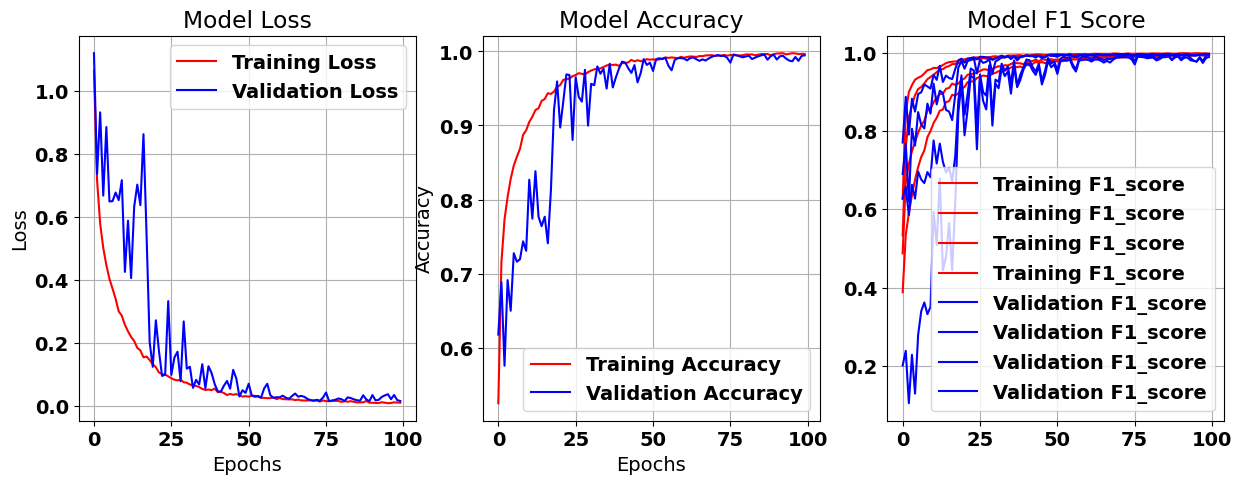

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    f1_score = history['f1_score']
    val_f1_score = history['val_f1_score']

    # # Loss
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.plot(train_loss, 'r', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 4, 2)
    plt.plot(train_acc, 'r', label='Training Accuracy')
    plt.plot(val_acc, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()

    # F-1 Score
    plt.subplot(1, 4, 3)
    plt.plot(f1_score, 'r', label='Training F1_score')
    plt.plot(val_f1_score, 'b', label='Validation F1_score')
    plt.title('Model F1 Score')
    plt.legend()
    plt.grid()
    plt.show()
plot_metrics(history)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming model, test_data, and other necessary imports are defined elsewhere in your code

predicted_classes = []
ground_truth = []

# Make predictions on each batch
for images, labels in test_data:
    preds = model.predict(images, verbose=0)
    predicted_classes.extend(np.argmax(preds, axis=1))
    ground_truth.extend(np.argmax(labels.numpy(), axis=1))

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(ground_truth, predicted_classes)

# Now, confusion_matrix_result is a NumPy array representing the confusion matrix
# You can print it or use it for further analysis
print(confusion_matrix_result)


[[1182   18    0    0]
 [   6 1181   23   14]
 [   6    8 1593   13]
 [   2    4    0 1192]]


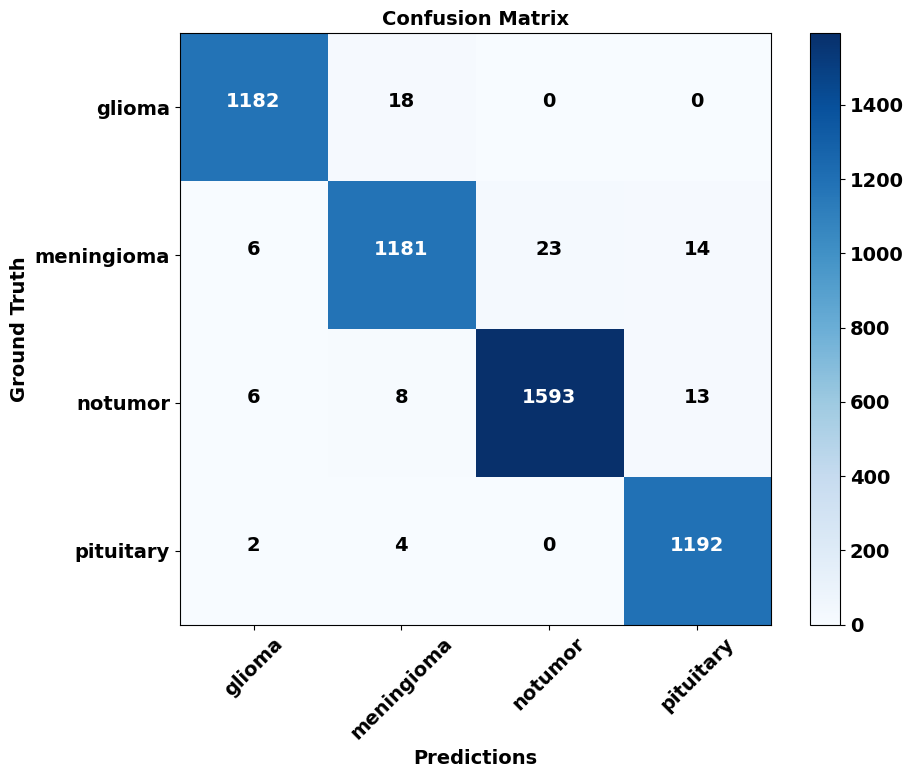

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming confusion_matrix_result and class_names_test are defined
plt.figure(figsize=(10, 8))

# Increase the font size and weight for better visibility
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'

plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.colorbar()

# Add labels to the axes
plt.xticks(np.arange(len(class_names_test)), class_names_test, rotation=45)
plt.yticks(np.arange(len(class_names_test)), class_names_test)

# Label the axes
plt.xlabel('Predictions', fontsize=14, weight='bold')
plt.ylabel('Ground Truth', fontsize=14, weight='bold')

# Show numbers inside cells
thresh = confusion_matrix_result.max() / 2.
for i in range(confusion_matrix_result.shape[0]):
    for j in range(confusion_matrix_result.shape[1]):
        plt.text(j, i, format(confusion_matrix_result[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_result[i, j] > thresh else "black",
                 fontsize=14, weight='bold')  # Apply bold and increased font size here

plt.tight_layout()
plt.show()


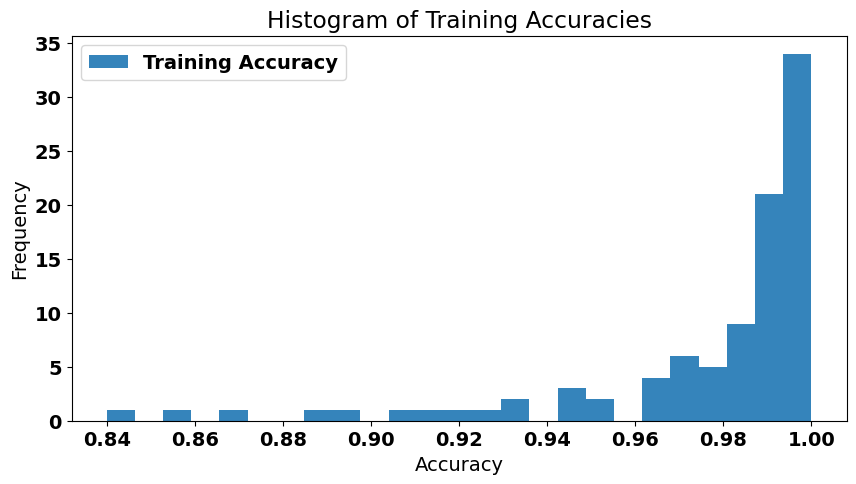

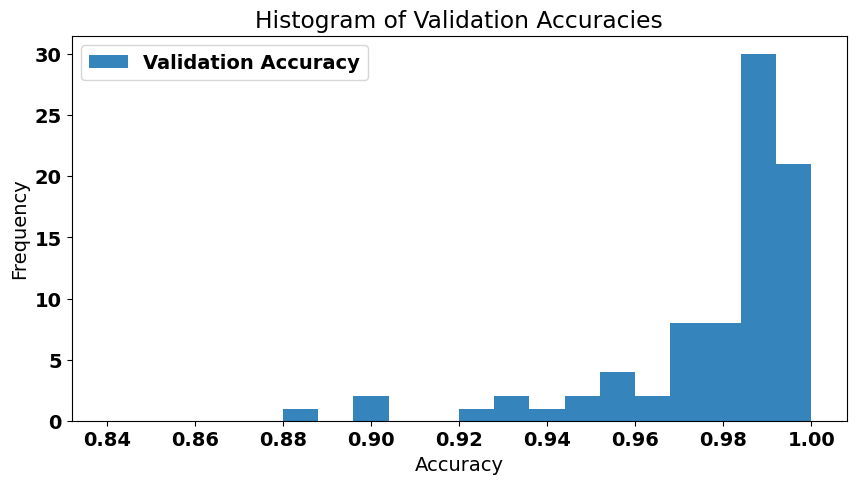

In [ ]:
import matplotlib.pyplot as plt

# Assuming history contains keys for 'accuracy' and 'val_accuracy'
train_accuracies = history['accuracy']
val_accuracies = history['val_accuracy']

# Plot histogram for training accuracies
plt.figure(figsize=(10, 5))
plt.hist(train_accuracies, bins=25, range=(0.84, 1), alpha=0.9, label='Training Accuracy')
plt.title('Histogram of Training Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot histogram for validation accuracies
plt.figure(figsize=(10, 5))
plt.hist(val_accuracies, bins=20, range=(0.84, 1), alpha=0.9, label='Validation Accuracy')
plt.title('Histogram of Validation Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


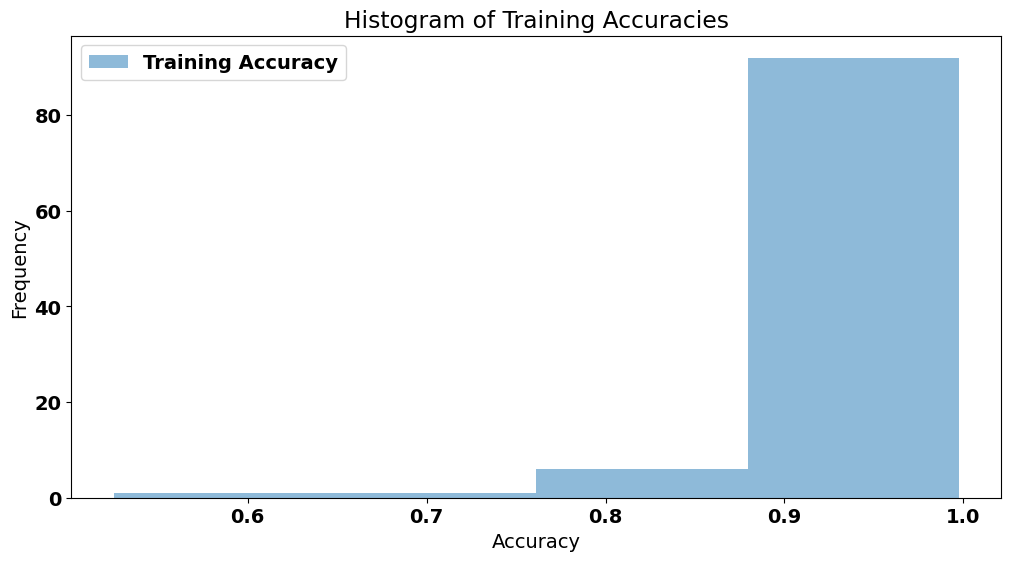

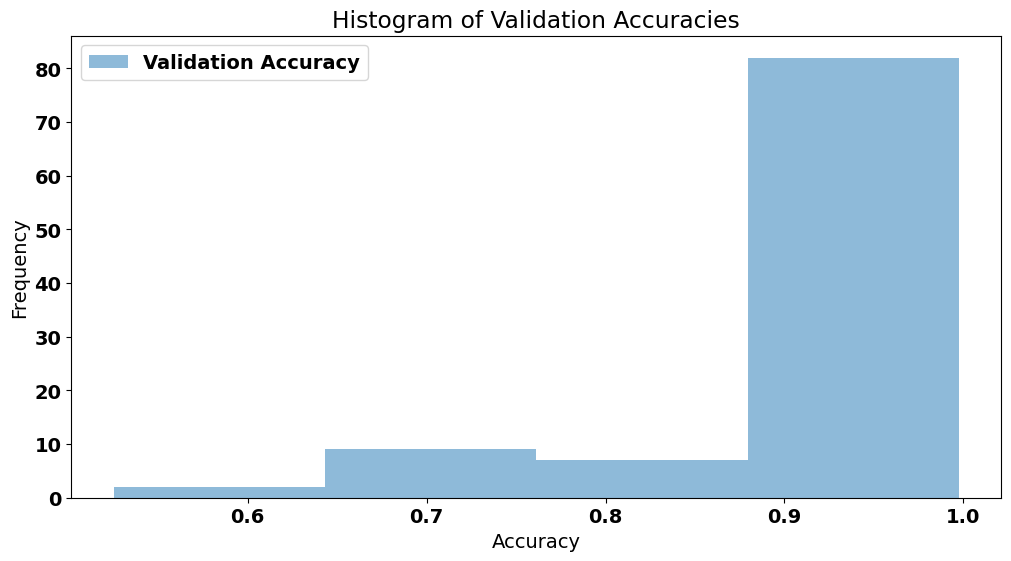

In [ ]:
import matplotlib.pyplot as plt

# Assuming history contains keys for 'accuracy' and 'val_accuracy'
train_accuracies = history['accuracy']
val_accuracies = history['val_accuracy']

# Calculate the number of bins dynamically based on the range of accuracies
min_acc = min(min(train_accuracies), min(val_accuracies))
max_acc = max(max(train_accuracies), max(val_accuracies))
num_bins = int((max_acc - min_acc) * 10)  # Adjust the multiplier as needed

# Plot histogram for training accuracies
plt.figure(figsize=(12, 6))
plt.hist(train_accuracies, bins=num_bins, alpha=0.5, label='Training Accuracy', range=[min_acc, max_acc])
plt.title('Histogram of Training Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot histogram for validation accuracies
plt.figure(figsize=(12, 6))
plt.hist(val_accuracies, bins=num_bins, alpha=0.5, label='Validation Accuracy', range=[min_acc, max_acc])
plt.title('Histogram of Validation Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf

# List of class names
class_names = ["Class A", "Class B", "Class C", "Class D"]

# Function to get class distribution
def get_class_distribution(dataset):
    class_counts = {name: 0 for name in class_names}  # Use class names as keys

    # Iterate over the dataset
    for images, labels in dataset:
        # Convert labels to numpy array if not already
        labels_np = labels.numpy() if isinstance(labels, tf.Tensor) else labels

        # Flatten the one-hot encoded labels to 1D array
        labels_1d = labels_np.flatten()

        # Increment count for each class
        for label in labels_1d:
            if label == 1:  # Only consider the class indicated by 1
                class_name = class_names[labels_1d.argmax()]  # Find the class name using argmax
                class_counts[class_name] += 1  # Increment count for the found class name

    return class_counts

# Assuming train_data and validation_data are TensorFlow datasets
total_batches_validation = tf.data.experimental.cardinality(validation_data).numpy()
total_images_validation = total_batches_validation * 64  # Assuming batch size is 64
total_batches_training = tf.data.experimental.cardinality(train_data).numpy()
total_images_training = total_batches_training * 64  # Assuming batch size is 64

print("Total number of images in validation dataset:", total_images_validation)
print("Total number of images in training dataset:", total_images_training)

# Get class distributions
try:
    train_class_distribution = get_class_distribution(train_data)
    validation_class_distribution = get_class_distribution(validation_data)

    print("Training Class Distribution:", train_class_distribution)
    print("Validation Class Distribution:", validation_class_distribution)
except Exception as e:
    print("Error occurred:", str(e))


Total number of images in validation dataset: 4544
Total number of images in training dataset: 18368
Training Class Distribution: {'Class A': 4224, 'Class B': 3520, 'Class C': 5691, 'Class D': 4928}
Validation Class Distribution: {'Class A': 832, 'Class B': 896, 'Class C': 1664, 'Class D': 1152}


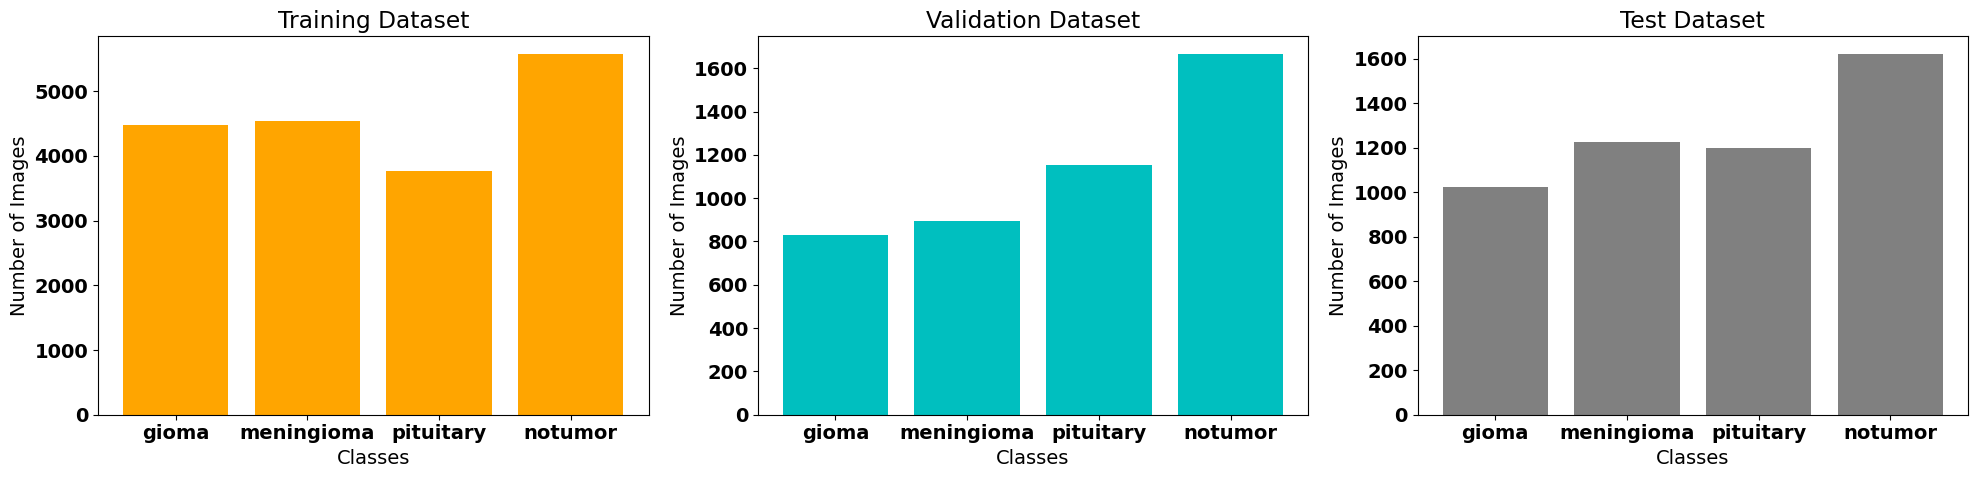

In [ ]:
def plot_class_distribution(train_dist, val_dist, test_dist):
    classes = list(train_dist.keys())
    train_counts = list(train_dist.values())
    val_counts = list(val_dist.values())
    test_counts = list(test_dist.values())

    x = range(len(classes))

    plt.figure(figsize=(20, 5))

    # Training set
    plt.subplot(1, 3, 1)
    plt.bar(x, train_counts, color='orange')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Training Dataset')
    plt.xticks(x, classes)
    # plt.grid(axis='y')

    # Validation set
    plt.subplot(1, 3, 2)
    plt.bar(x, val_counts, color='c')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Validation Dataset')
    plt.xticks(x, classes)
    # plt.grid(axis='y')

    # Test set
    plt.subplot(1, 3, 3)
    plt.bar(x, test_counts, color='grey')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Test Dataset')
    plt.xticks(x, classes)
    # plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

# Example class distribution dictionaries
train_class_distribution = {'gioma': 4480, 'meningioma': 4544, 'pituitary':3771, 'notumor':5568}
val_class_distribution = {'gioma': 832, 'meningioma': 896, 'pituitary':1152, 'notumor':  1664}
test_class_distribution = {'gioma': 1024, 'meningioma': 1224, 'pituitary': 1198, 'notumor': 1620}

# Call the functions

plot_class_distribution(train_class_distribution, val_class_distribution, test_class_distribution)
